#### Salary Threshold Classification


Target: Whether a player earns above a certain salary (e.g., $5M)

Features:

- Performance metrics

- Awards and All-Star appearances

- Team market size (from Teams.csv)

Use case: Predict high-salary contracts based on performance and visibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


Step 1: Load and Label Salary Data

In [2]:
# Load salary data
salaries = pd.read_csv("data/Salaries.csv")

# Create binary target: 1 if salary > $5M, else 0
salaries["high_salary"] = (salaries["salary"] > 5_000_000).astype(int)

# Check class balance
print(salaries["high_salary"].value_counts())

high_salary
0    23253
1     3175
Name: count, dtype: int64


In [3]:
salaries.head()

,yearID,teamID,lgID,playerID,salary,high_salary
0,2004,SFN,NL,aardsda01,300000,0
1,2007,CHA,AL,aardsda01,387500,0
2,2008,BOS,AL,aardsda01,403250,0
3,2009,SEA,AL,aardsda01,419000,0
4,2010,SEA,AL,aardsda01,2750000,0


Step 2: Merge Performance and Biographical Features

In [4]:
# Load other datasets
batting = pd.read_csv("data/Batting.csv")
people = pd.read_csv("data/People.csv")
awards = pd.read_csv("data/AwardsPlayers.csv")
teams = pd.read_csv("data/Teams.csv")


print(batting.head())
print(people.head())
print(awards.head())
print(teams.head())

    playerID  yearID  stint teamID lgID   G  G_batting  AB  R  H  ...   SB  \
0  aardsda01    2004      1    SFN   NL  11        NaN   0  0  0  ...  0.0   
1  aardsda01    2006      1    CHN   NL  45        NaN   2  0  0  ...  0.0   
2  aardsda01    2007      1    CHA   AL  25        NaN   0  0  0  ...  0.0   
3  aardsda01    2008      1    BOS   AL  47        NaN   1  0  0  ...  0.0   
4  aardsda01    2009      1    SEA   AL  73        NaN   0  0  0  ...  0.0   

    CS  BB   SO  IBB  HBP   SH   SF  GIDP  G_old  
0  0.0   0  0.0  0.0  0.0  0.0  0.0   0.0    NaN  
1  0.0   0  0.0  0.0  0.0  1.0  0.0   0.0    NaN  
2  0.0   0  0.0  0.0  0.0  0.0  0.0   0.0    NaN  
3  0.0   0  1.0  0.0  0.0  0.0  0.0   0.0    NaN  
4  0.0   0  0.0  0.0  0.0  0.0  0.0   0.0    NaN  

[5 rows x 24 columns]
   ID   playerID  birthYear  birthMonth  birthDay   birthCity birthCountry  \
0   1  aardsda01     1981.0        12.0      27.0      Denver          USA   
1   2  aaronha01     1934.0         2.0       

In [5]:
print(teams.columns.tolist())

# Ensure teamID and yearID are strings (if needed)
salaries["teamID"] = salaries["teamID"].astype(str)
teams["teamID"] = teams["teamID"].astype(str)



['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']


In [6]:
# Merge batting stats
merged = pd.merge(salaries,  batting.drop(columns=["teamID"]), on=["playerID", "yearID"], how="left")

# Merge biographical info
merged = pd.merge(merged, people[["playerID", "birthYear", "height", "weight", "bats", "throws"]], on="playerID", how="left")

# Merge team-level features
merged = pd.merge(
    merged,
    teams[["yearID", "teamID", "W", "attendance"]],
    on=["yearID", "teamID"],
    how="left"
)

# Merge awards (flag if player won any award that year)
awards["won_award"] = 1
award_flags = awards.groupby(["playerID", "yearID"])["won_award"].max().reset_index()
merged = pd.merge(merged, award_flags, on=["playerID", "yearID"], how="left")
merged["won_award"] = merged["won_award"].fillna(0)

merged.head()

,yearID,teamID,lgID_x,playerID,salary,high_salary,stint,lgID_y,G,G_batting,...,GIDP,G_old,birthYear,height,weight,bats,throws,W,attendance,won_award
0,2004,SFN,NL,aardsda01,300000,0,1.0,NL,11.0,NaN,...,0.0,NaN,1981.0,75.0,215.0,R,R,91,3256854.0,0.0
1,2007,CHA,AL,aardsda01,387500,0,1.0,AL,25.0,NaN,...,0.0,NaN,1981.0,75.0,215.0,R,R,72,2684395.0,0.0
2,2008,BOS,AL,aardsda01,403250,0,1.0,AL,47.0,NaN,...,0.0,NaN,1981.0,75.0,215.0,R,R,95,3048250.0,0.0
3,2009,SEA,AL,aardsda01,419000,0,1.0,AL,73.0,NaN,...,0.0,NaN,1981.0,75.0,215.0,R,R,85,2195533.0,0.0
4,2010,SEA,AL,aardsda01,2750000,0,1.0,AL,53.0,NaN,...,0.0,NaN,1981.0,75.0,215.0,R,R,61,2085488.0,0.0


Step 3: Feature Engineering

In [ ]:
# Age calculation
merged["age"] = merged["yearID"] - merged["birthYear"]

# Batting average
merged["AVG"] = merged["H"] / merged["AB"]
merged["AVG"] = merged["AVG"].fillna(0)

# Fill missing values
merged.fillna(0, inplace=True)

# Select features
features = ["age", "height", "weight", "HR", "RBI", "BB", "SO", "SB", "AVG", "W", "attendance", "won_award"]
X = merged[features]
y = merged["high_salary"]


: 

Step 4: Train Logistic Regression Model

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Step 5: Interpret Coefficients

In [ ]:
# Feature importance
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(coeffs)


       Feature   Coefficient
0          age  1.696661e-01
3           HR  5.181447e-02
2       weight  3.072520e-02
11   won_award  1.179933e-02
5           BB  7.886079e-03
4          RBI  2.854647e-03
10  attendance  7.123724e-07
8          AVG -7.093168e-04
6           SO -3.025524e-03
7           SB -3.970565e-03
9            W -1.144841e-02
1       height -1.997103e-01


Compute Probabilities and AUC

In [ ]:
# Predict probabilities for class 1 (high salary)
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.3f}")


AUC Score: 0.808


Plot ROC Curve

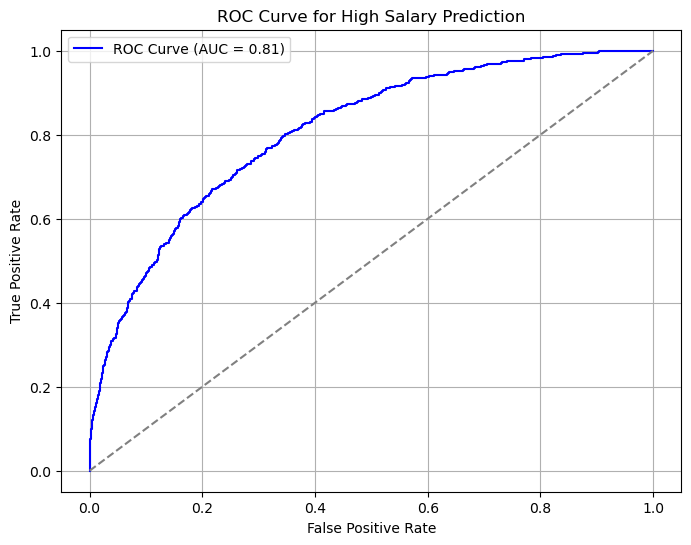

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for High Salary Prediction")
plt.legend()
plt.grid(True)
plt.show()


Salary Probability Table for 2024

Filter for 2016 Players

In [ ]:
latest_year = 2016
latest_players = merged[merged["yearID"] == latest_year].copy()


Filter for 2016 Players

In [ ]:
# Predict probability of earning > $5M
latest_players["salary_probability"] = model.predict_proba(latest_players[features])[:, 1]


In [ ]:
# Add player name if available
if "nameFirst" in latest_players.columns and "nameLast" in latest_players.columns:
    latest_players["player_name"] = latest_players["nameFirst"] + " " + latest_players["nameLast"]
else:
    latest_players["player_name"] = latest_players["playerID"]

# Select final columns
salary_table = latest_players[["player_name", "teamID", "salary", "salary_probability"]].sort_values(by="salary_probability", ascending=False)


In [ ]:
print(salary_table.head(20))


      player_name teamID    salary  salary_probability
5209    colonba01    NYN   7250000            0.943556
19454   ortizda01    BOS  16000000            0.941995
7413    encared01    TOR  10000000            0.907190
3840    cabremi01    DET  28000000            0.874583
1848    beltrad01    TEX  18000000            0.862777
21177   pujolal01    LAA  25000000            0.850319
5790     cruzne02    SEA  14250000            0.825046
16393   martivi01    DET  18000000            0.810831
4082     canoro01    SEA  24000000            0.804794
6711    donaljo02    TOR  11650000            0.770277
17884   moralke01    KCA   9000000            0.767368
1868    beltrca01    NYA  15000000            0.758584
7951    fieldpr01    TEX  24000000            0.757755
1520    bautijo02    TOR  14000000            0.754811
11963   hollima01    SLN  17000000            0.739564
21421   ramirha01    BOS  22750000            0.737871
23055   sabatcc01    NYA  25000000            0.724105
16347   ma